<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language(could be sequences text or speech).
Another common term for NLP problems is sequence to sequence problems(seq2seq).

## Check for GPU 

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac288dce-214e-2b3c-6fa3-b466ad650643)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, compare_historys, plot_loss_curves

--2021-08-07 02:05:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-07 02:05:19 (83.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset(text samples of Tweets labelled as disaster or not disaster).

See the original source here : https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-08-07 02:05:21--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-08-07 02:05:21 (127 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
# Unzip data
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in , one way to do sou would be to use Python : https://realpython.com/python-csv/

But I prefer to get visual straight away.
So another way to do is to use pandas...



In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe

train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like ?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?

train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

 > **Note** : If your data is not balanced, there are some things you can do for imbalanced dataset
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [9]:
# How many total samples ?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
import random
random_index = random.randint(0, len(train_df)-5)
random_index

5877

In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples() :
  _,text,target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")


Target: 0 (not real disaster)
Text:
Hero you can 't swim lonely guy help me my solution is not yours lifeguard i hated killing people how destroyed it http://t.co/pAztDblgYk

---

Target: 0 (not real disaster)
Text:
If Locke has to pitch in the playoffs it's not a disaster but they should absolutely positively never let him pitch the sixth inning.

---

Target: 0 (not real disaster)
Text:
PUT SANDSTORM DOWN!!!! https://t.co/EfKCoegJck

---

Target: 1 (real disaster)
Text:
Preacher faces UK terrorism charges http://t.co/daPlllFuqK

---

Target: 0 (not real disaster)
Text:
I added a video to a @YouTube playlist http://t.co/1vjAlJA1SX GTA 5 Funny Moments - 'OBLITERATION!' (GTA 5 Online Funny Moments)

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                              train_df_shuffled["target"].to_numpy(),
                                                                              test_size=0.1, #use 10% of training data for validaton
                                                                              random_state=42)



In [14]:
#Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
# Check the  first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Tokenization vs Embedding

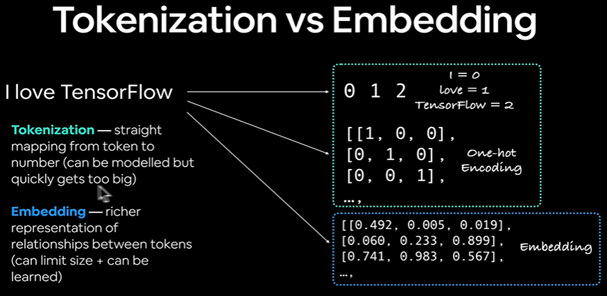

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do  before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely :
* Tokenization : direct mapping of token(a token could be a word or character) to number
* Embedding : create a matrix of feature vector for each token(the size of the feature vector can be defined and this embedding can be learned)


### Text vectorization (tokenization)

In [16]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Link to TextVectorization : https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create group of n-words?
                                    output_mode="int", # how to map tokens to int
                                    output_sequence_length=None, # how long do you want your sequence to be
                                    pad_to_max_tokens = True)


In [18]:
len(train_sentences[0].split())

7

In [19]:
# Find the average number of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length= 10000 # max number of words to have in our vocabulary
max_length = 15 # max length  our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode ="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it.
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
news@@ Refugio oil spill may have been costlier bigger than projected http://t.co/jhpdSSVhvE         

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  58,  877,  254,  385,  133,   24,   59,  903,  825,   76,  837,
        5439,    0,    0,    0]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most commom words: {top_5_words}" )
print(f"5 least commom words:{bottom_5_words}")

Number of words in vocab: 10000
5 most commom words: ['', '[UNK]', 'the', 'a', 'in']
5 least commom words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our emebedding, we're going to use the TensorFlow's Embedding layer :https://keras.io/api/layers/core_layers/embedding/

The parameters we care about for our embedding layer :
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector of 100 long.
* `input_length` = length of the sequences being passed to the embedding layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, #output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

In [26]:
# Get a random sentence from the training set 
random_sentence = random.choice(train_sentences)
print(f"Original text :\n {random_sentence}\
        \n\nEmbedded version:")

#Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text :
 Free Ebay Sniping RT? http://t.co/RqIPGQslT6 Chevrolet : Avalanche Ltz Lifted 4x4 Truck ?Please Favorite &amp; Share        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0053209 ,  0.03003695, -0.01595216, ..., -0.01512256,
          0.04333439, -0.0286806 ],
        [ 0.00297137, -0.04294214,  0.00342194, ..., -0.00202643,
          0.01206907, -0.04681056],
        [-0.00641827,  0.02650574, -0.03368302, ...,  0.04750237,
         -0.00497609, -0.02723236],
        ...,
        [-0.03638971,  0.04170842, -0.01429451, ...,  0.04948768,
         -0.02401244,  0.04996468],
        [-0.03884267, -0.04399663, -0.01274395, ...,  0.04637611,
          0.0006646 , -0.04501568],
        [-0.00988029,  0.01337491, -0.0251316 , ...,  0.02391399,
          0.01850525, -0.01910255]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-5.3208955e-03,  3.0036952e-02, -1.5952159e-02, -5.7564266e-03,
         3.6511008e-02,  4.7212426e-02, -3.3291355e-02, -2.4296820e-02,
        -3.0510759e-02,  3.1113956e-02,  4.5288216e-02, -3.7372112e-05,
        -5.0470605e-03, -3.9294790e-02, -3.7641905e-02, -1.5087388e-02,
        -1.1095405e-03,  4.2817567e-02, -3.2369841e-02,  1.9106302e-02,
         7.1329847e-03, -3.3040427e-02, -4.3378592e-02,  1.3447847e-02,
         4.1044857e-02,  1.6565453e-02,  1.7847907e-02, -1.5161119e-02,
         3.7759542e-04, -1.1094283e-02, -3.1960703e-02, -3.7991464e-02,
        -1.1352550e-02,  3.0828487e-02, -3.9448224e-02,  3.1993065e-02,
         4.7768284e-02, -6.4989924e-03, -1.9375874e-02, -1.1557795e-02,
        -2.4964869e-02, -2.3487961e-02,  1.9483101e-02,  3.2989789e-02,
        -3.9533090e-02, -3.4061097e-02, -1.9780552e-02,  4.7812250e-02,
        -1.6726255e-03,  3.3512499e-02, -2.6128722e-02,  3.8514029e-02,
         3.9197

## Modelling a text dataset(running a series of experiments)

Now we've got a way to turn our text sequence into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0 : Naive Bayes (baseline), this is from SkLearn ML https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1 : Feed-forward neural network(dense model)
* Model 2 : LSTM model (RNN)
* Model 3 : GRU model (RNN)
* Model 4 : Bidirectional-LSTM model (RNN)
* Model 5 : 1D Convolutional Neural Network (CNN)
* Model 6 : TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7 : Same as model 6 with 10% of the training data

How we are going to approach all of these?
Use the standard steps in modelling with tensorflow :

* Create a model
* Build a model
* Fit a model
* Evaluate our model



### Model 0 : Getting a baseline

As with all machine leanring modelling experiments, it's important to create a baseline so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note** : It's common practice to use non-DL  (Deep Learning) algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # covert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text                    
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)

print(f"Our baseline model achieves an accuracy of : {baseline_score *100 : .2f}%")

Our baseline model achieves an accuracy of :  79.27%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [31]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time,however, this will be cumbersome and could easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many evaluation methods, please refer the Sklearn documentation :
https://scikit-learn.org/stable/modules/model_evaluation.html

In [32]:
# Function to evaluate accuracy, precision, recall , f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred) :
  """
  Calculate model accuracy, precision , recall ad f1-score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy" : model_accuracy,
                   "precision" : model_precision,
                   "recall" : model_recall,
                   "f1" : model_f1}
  return model_results





In [33]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [34]:
# We already created the function to our helper function
#from helper_functions import calculate_results


### Model 1 : A simple dense model

In [35]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [36]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector 
#x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary ouputs so use sigmoid
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")


In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [39]:
# Fit thr model
model_1_history = model_1.fit(train_sentences, 
                              y = train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210807-020530
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6117 - accuracy: 0.6930 - val_loss: 0.5367 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4408 - accuracy: 0.8186 - val_loss: 0.4698 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3470 - accuracy: 0.8603 - val_loss: 0.4556 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2845 - accuracy: 0.8902 - val_loss: 0.4654 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2377 - accuracy: 0.9123 - val_loss: 0.4833 - val_accuracy: 0.7861


In [40]:
# Check the results 
results_model_1 = model_1.evaluate(val_sentences, val_labels)
results_model_1

24/24 [==============================] - 0s 3ms/step - loss: 0.4833 - accuracy: 0.7861


[0.4833150804042816, 0.7860892415046692]

In [41]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [42]:
# look at a single prediction
model_1_pred_probs[0]

array([0.28053078], dtype=float32)

In [43]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.28053078],
       [0.7745745 ],
       [0.9977591 ],
       [0.07919437],
       [0.10901017],
       [0.93544817],
       [0.9187559 ],
       [0.99316955],
       [0.9622571 ],
       [0.20094723]], dtype=float32)

In [44]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [45]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'f1': 0.7820552596075473,
 'precision': 0.7941779811737785,
 'recall': 0.7860892388451444}

In [46]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [47]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [48]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [49]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)


(10000, 128)


Now we've got the embedding matrix our model has learned ot represent our tokens, let's see how we can use visualize it.

To do so, TensorFlow has a handy tool called projector : https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings https://www.tensorflow.org/text/guide/word_embeddings

In [51]:
# Create embedding files (we got thie from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [52]:
# Download the vectors locally
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the files above can be visualize them using https://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

**Resources** If you'd like to know more about embeddings, I'd encourage you to check out:
 * Jay Alammar's visualized word2vec post : https://jalammar.github.io/illustrated-word2vec/
 * TensorFlow's Word Embeddings guide : https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of later input.


**Resources** : If you want to learn the understanding of RNN , here are some of the useful links :
* MIT's sequence modelling lecture https://www.youtube.com/watch?v=qjrad0V0uJE
* Chris Olah's intro to LSTMs : https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks : http://karpathy.github.io/2015/05/21/rnn-effectiveness/

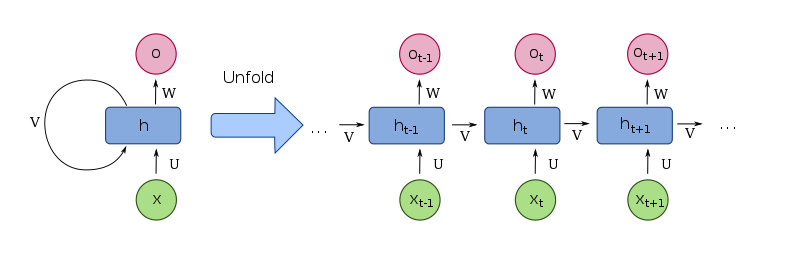

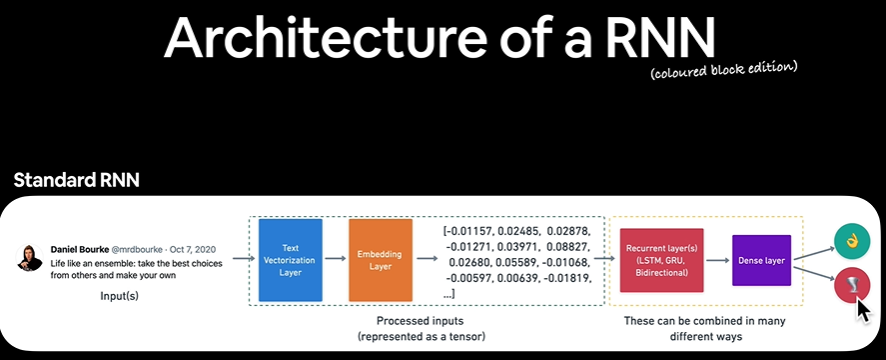

### Model 2 : LSTM

LSTM - Long Short Term Memory ( one of the most popular LSTM cells)

Our structure of an RNN typically looks like this :

```
Input(text) -> Tokenize -> Embedding -> Layers(RNNs/dense) -> Output (label probability)
```

Check documentation here : https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

Tanh Activation functions : https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [53]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True 
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
#print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


In [54]:
# Check model summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,362,497
Trainable params: 1,362,497
Non-trainable params: 0
____________________________________________

In [55]:
# Compile the model_2
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [56]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              y = train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210807-020553
Epoch 1/5
215/215 [==============================] - 12s 27ms/step - loss: 0.2170 - accuracy: 0.9199 - val_loss: 0.6102 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1577 - accuracy: 0.9421 - val_loss: 0.6777 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1297 - accuracy: 0.9511 - val_loss: 0.7151 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1054 - accuracy: 0.9594 - val_loss: 0.7328 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0843 - accuracy: 0.9651 - val_loss: 0.9078 - val_accuracy: 0.7795


In [57]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[2.4881173e-02],
       [8.6917067e-01],
       [9.9993801e-01],
       [9.9710599e-02],
       [1.6365247e-04],
       [9.9976093e-01],
       [9.5661867e-01],
       [9.9995506e-01],
       [9.9994326e-01],
       [3.3701795e-01]], dtype=float32)

In [58]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
# Calculate model 2 results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 77.95275590551181,
 'f1': 0.7782139444386276,
 'precision': 0.7800661437025787,
 'recall': 0.7795275590551181}

In [60]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3 : GRU

Gated Recurrent Unit
Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU


In [61]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.GRU(64, return_sequences=True)(x) # when you're stacking LSTM/GRU set return sequence = True
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x)
#print(x.shape)
#x = layers.GRU(64)(x)
#print(x.shape)
# Dense layer
#x = layers.Dense(64, activation="relu")(x)
#print(x.shape)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [62]:
# Model 3 Summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Fit the model
model_3_history = model_3.fit(train_sentences, 
                              y = train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210807-020638
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1549 - accuracy: 0.9369 - val_loss: 0.8292 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0837 - accuracy: 0.9704 - val_loss: 0.9327 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0677 - accuracy: 0.9724 - val_loss: 1.0852 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0580 - accuracy: 0.9766 - val_loss: 1.0052 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0550 - accuracy: 0.9755 - val_loss: 1.1124 - val_accuracy: 0.7756


In [65]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[2.2101270e-02],
       [7.9189664e-01],
       [9.9995458e-01],
       [6.0436573e-02],
       [1.2708169e-04],
       [9.9982160e-01],
       [9.8404455e-01],
       [9.9996257e-01],
       [9.9994862e-01],
       [8.7722087e-01]], dtype=float32)

In [66]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.55905511811024,
 'f1': 0.7743062301518678,
 'precision': 0.7759863909628747,
 'recall': 0.7755905511811023}

### Model 4 : Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, a bidirectional RNN goes from right to left as well as left to right.

Another popular and effective RNN component is the Bi-directional.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [68]:
## Build a birectional RNN in TensorFlow
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [69]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Fit the model
model_4.fit(train_sentences, 
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210807-020700
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.1110 - accuracy: 0.9669 - val_loss: 0.9667 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0538 - accuracy: 0.9771 - val_loss: 0.9076 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0455 - accuracy: 0.9797 - val_loss: 1.1728 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0441 - accuracy: 0.9783 - val_loss: 1.2640 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0405 - accuracy: 0.9807 - val_loss: 1.4729 - val_accuracy: 0.7638


In [72]:
# Check model predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[4.2212806e-03],
       [8.3777338e-01],
       [9.9995208e-01],
       [2.7390778e-01],
       [1.0113524e-05],
       [9.9948990e-01],
       [9.7079092e-01],
       [9.9997604e-01],
       [9.9996126e-01],
       [9.9840218e-01]], dtype=float32)

In [73]:
# Convert model 4 pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
# Calculate results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'f1': 0.7632395197882116,
 'precision': 0.7633788771640306,
 'recall': 0.7637795275590551}

## Convolution Neural Networks for Text(and other types of sequences)

We've use CNNs for images but images are typically 2D (height x width)... howver our text data is 1D.

Previously we've used Conv2D for our image data but we're going to use Conv1D.
The typical structure of a Conv1D model for  sequences (in our case, text) :

```
Inputs(text) -> Tokenization -> Embedding -> Layer(s) (typically  Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5 : Conv1D

For different explanations of paramters see :
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can related to 1D)

* Difference between same and valid padding : https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=VALID%20%3A%20Don't%20apply%20any,filter%20and%20stride%20you%20specified.


In [75]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
 
conv_1d = layers.Conv1D(filters = 32,  # number of hidden units
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks to 5 words at at time)
                        activation="relu",
                        strides=1, #default
                        padding="same") # default="valid", the output is smaller than the input shape. "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1D layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # Equivalent to "get most important feature" or "get the feature with highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [76]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00288088, -0.02894426,  0.02144892, ...,  0.02568233,
          0.0520128 , -0.04309252],
        [ 0.01158911, -0.03218063, -0.01019725, ..., -0.0166333 ,
          0.04362177, -0.01331481],
        [ 0.04607859, -0.04822852,  0.01291464, ..., -0.00540199,
          0.04166798,  0.03600085],
        ...,
        [-0.01840484, -0.01374829, -0.01202649, ..., -0.04284095,
          0.00016997,  0.00294751],
        [-0.01840484, -0.01374829, -0.01202649, ..., -0.04284095,
          0.00016997,  0.00294751],
        [-0.01840484, -0.01374829, -0.01202649, ..., -0.04284095,
          0.00016997,  0.00294751]]], dtype=float32)>

In [77]:
# Uncomment here to get some explanation
#conv_1d_output

In [78]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.0316649 , 0.08462553, 0.04065392, 0.03392129, 0.01788498,
        0.0905042 , 0.08108474, 0.00851698, 0.01576389, 0.0912873 ,
        0.03347979, 0.02478206, 0.09794509, 0.04436603, 0.01749282,
        0.04525109, 0.0410498 , 0.03144106, 0.04689078, 0.02894082,
        0.02036255, 0.10341525, 0.00770821, 0.04152854, 0.05079519,
        0.08258729, 0.08292805, 0.02062237, 0.05594284, 0.12605757,
        0.01466934, 0.04793543]], dtype=float32)>

In [79]:
# Create the 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, # number of hidden units
                  kernel_size=5, # look at 5 words at a time n-gram =5
                  padding="valid", # default value
                  strides=1, # default value
                  activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# Pass dense layer if required
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs)


In [80]:
# Check model summary
model_5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
___________________________________________________

In [81]:
# Compile the Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [82]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20210807-020751
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1242 - accuracy: 0.9593 - val_loss: 0.8966 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0760 - accuracy: 0.9708 - val_loss: 1.0412 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0608 - accuracy: 0.9745 - val_loss: 1.1260 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0545 - accuracy: 0.9778 - val_loss: 1.1859 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0513 - accuracy: 0.9785 - val_loss: 1.1924 - val_accuracy: 0.7520


In [83]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[8.9027412e-02],
       [9.6944046e-01],
       [9.9995613e-01],
       [1.2337660e-01],
       [4.9015696e-08],
       [9.9786383e-01],
       [9.6285784e-01],
       [9.9998260e-01],
       [9.9999940e-01],
       [9.3260694e-01]], dtype=float32)

In [84]:
# Convert preds for model 5 into lables
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [85]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 75.19685039370079,
 'f1': 0.7505489912204856,
 'precision': 0.7519989531509904,
 'recall': 0.7519685039370079}

In [86]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6 : Tensorflow Hub Pretrained Sentence Encoder

Now we've built a few of our models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder :
https://tfhub.dev/google/universal-sentence-encoder/4

In [87]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples=embed([ sample_sentence,  
                     "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50]) 


tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [88]:
embed_samples[0].shape  # 512 feature vector

TensorShape([512])

In [89]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape=[],
                                        dtype="string",
                                        trainable=False, # default value
                                        name="USE")


In [90]:
# Create model using the Sequential API

model_6 = tf.keras.Sequential([
        sentence_encoder_layer,
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid", name="output_layer")                                       
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [91]:
# Check model summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [92]:
# Train a classifer model on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences, 
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210807-020832
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.5076 - accuracy: 0.7806 - val_loss: 0.4482 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4155 - accuracy: 0.8173 - val_loss: 0.4433 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4012 - accuracy: 0.8221 - val_loss: 0.4347 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3930 - accuracy: 0.8289 - val_loss: 0.4302 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3856 - accuracy: 0.8321 - val_loss: 0.4256 - val_accuracy: 0.8150


In [93]:
# Check the USE TF Hub Model predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.20636   ],
       [0.7948796 ],
       [0.9911793 ],
       [0.24564771],
       [0.7744535 ],
       [0.74314684],
       [0.98497874],
       [0.97999334],
       [0.9609692 ],
       [0.08277463]], dtype=float32)

In [94]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
# Calculate the USE TF model performance
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8138139523860313,
 'precision': 0.8161852632862286,
 'recall': 0.8149606299212598}

In [96]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [97]:
len(train_df_shuffled)

7613

## Model 7 : TF HUb Pretrained USE but with 10% of training data

Transfer learnig really helps when you don't have a large dataset.
To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the train data

In [98]:
## NOTE : Making data spits like below leads to data leakage (model_7 trained on 10% data, outperformsn model_6 trained on 100% )
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING_SET
# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
##train_10_percent.head(), len(train_10_percent)

#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["target"].to_list()


> **Note** : Be *very* careful when creating training/val test splits that you don't leak across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true(a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut  and go back through to find where the error may lie.

In [99]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(.1 * len(train_sentences))

train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)


(685, 685)

In [100]:
# Check the number of each label in the udpated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [101]:
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [102]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as previous model you've created, you can use the `tf.keras.model.clone_model()` method, see more here:

https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [103]:
# Create the model 7 (clone from model 6)

#model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
#model_7.compile(loss="binary_crossentropy",
#                optimizer=tf.keras.optimizers.Adam(),
#                metrics=["accuracy"])

In [104]:
# Create the model7  (same  as model 6) but fit with 10% training set

model_7 = tf.keras.Sequential([
       sentence_encoder_layer,
       layers.Dense(64, activation="relu"),
       layers.Dense(1, activation="sigmoid", name="output_layer")                        
], name="model_7_USE")

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [105]:
# Get a summary(will be same as model _6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [106]:
# Fit the model (using the 10% percent train_data subsets)
model_7_results = model_7.fit(train_sentences_10_percent,
                              y = train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210807-020849
Epoch 1/5
22/22 [==============================] - 3s 92ms/step - loss: 0.6669 - accuracy: 0.6847 - val_loss: 0.6432 - val_accuracy: 0.7454
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5929 - accuracy: 0.8073 - val_loss: 0.5813 - val_accuracy: 0.7730
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5162 - accuracy: 0.8204 - val_loss: 0.5276 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4555 - accuracy: 0.8234 - val_loss: 0.4986 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4167 - accuracy: 0.8365 - val_loss: 0.4873 - val_accuracy: 0.7874


In [107]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.22114834],
       [0.6114091 ],
       [0.9280373 ],
       [0.33535025],
       [0.55918974],
       [0.7070435 ],
       [0.90058607],
       [0.81643605],
       [0.85126674],
       [0.1672143 ]], dtype=float32)

In [108]:
# Get the model preds
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [109]:
# Calculate model 7 peformance
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.74015748031496,
 'f1': 0.7855917300453952,
 'precision': 0.7891807386119943,
 'recall': 0.7874015748031497}

In [110]:
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8138139523860313,
 'precision': 0.8161852632862286,
 'recall': 0.8149606299212598}

## Comparing the performance of each of our models 

In [111]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline" : baseline_results,
                                  "1_simple_dense" : model_1_results,
                                  "2_lstm" : model_2_results,
                                  "3_gru" : model_3_results,
                                  "4_bidirectional" : model_4_results,
                                  "5_conv1d" : model_5_results,
                                  "6_tf_hub_use_encoder" : model_6_results,
                                  "7_tf_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.608924,0.794178,0.786089,0.782055
2_lstm,77.952756,0.780066,0.779528,0.778214
3_gru,77.559055,0.775986,0.775591,0.774306
4_bidirectional,76.377953,0.763379,0.763780,0.763240
5_conv1d,75.196850,0.751999,0.751969,0.750549
6_tf_hub_use_encoder,81.496063,0.816185,0.814961,0.813814
7_tf_use_encoder_10_percent,78.740157,0.789181,0.787402,0.785592


In [112]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] /100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.794178,0.786089,0.782055
2_lstm,0.779528,0.780066,0.779528,0.778214
3_gru,0.775591,0.775986,0.775591,0.774306
4_bidirectional,0.763780,0.763379,0.763780,0.763240
5_conv1d,0.751969,0.751999,0.751969,0.750549
6_tf_hub_use_encoder,0.814961,0.816185,0.814961,0.813814
7_tf_use_encoder_10_percent,0.787402,0.789181,0.787402,0.785592


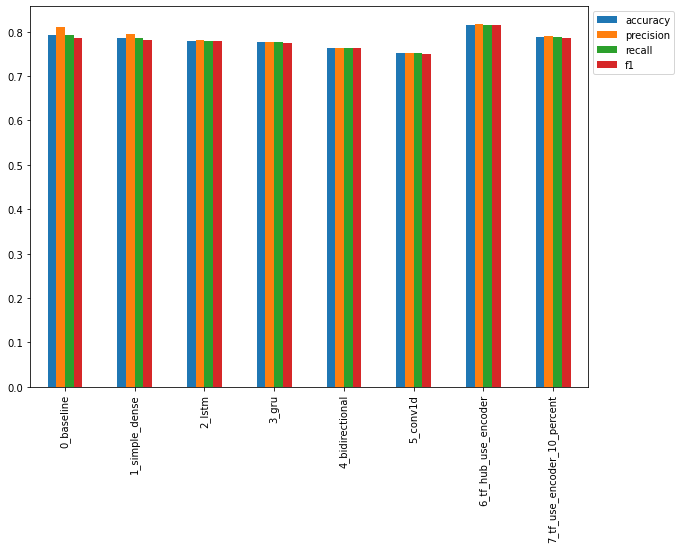

In [113]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

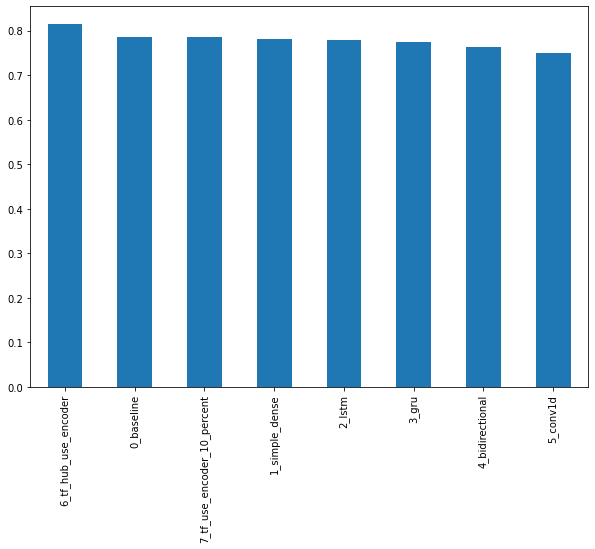

In [114]:
# Sort model results by f1-scores
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using Tensorboard.dev : https://tensorboard.dev/

In [116]:
# View TensorBoard logs of transfer learning modelling experiments(plus all of our other experiments)
# Upload TensorBoard dev records
! tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments ZTM TF Course Video" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset "\
  --one_shot # exit the uploader once uploading is finished.

2021-08-07 02:09:04.193618: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3

Now I've ran the cell above the modelling experiments are available at TensorBoard.dev
https://tensorboard.dev/experiment/EeYv3HwiQpyuG2gQipBGhA/

>**Resources** : TensorBoard is great for quickly tracking experiments, but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases : https://wandb.ai/site

In [117]:
# If you need to delete an experiment from tensorboard, you can run the following
#!tensorboard dev list

2021-08-07 02:14:22.518108: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/EeYv3HwiQpyuG2gQipBGhA/
	Name                 NLP Modelling Experiments ZTM TF Course Video
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset 
	Id                   EeYv3HwiQpyuG2gQipBGhA
	Created              2021-08-07 02:09:25 (5 minutes ago)
	Updated              2021-08-07 02:09:32 (4 minutes ago)
	Runs                 14
	Tags                 5
	Scalars              210
	Tensor bytes         0
	Binary object bytes  3388961
Total: 1 experiment(s)


In [118]:
# If you need to delete an experiment from TensorBoard, you can run the following :-
# !tensorboard dev delete --experiment_id EeYv3HwiQpyuG2gQipBGhA

2021-08-07 02:15:31.526506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Deleted experiment EeYv3HwiQpyuG2gQipBGhA.
